In [1]:
using Plots, Statistics, NaNStatistics, LinearAlgebra, Serialization, ParticleFilters, StatsBase, Distributions

include("../utils/import.jl")
using .Import

include("../utils/figs.jl")
using .Figs

fig_directory = "../fig/"
filetype = ".png"
function save(name::String)
    savefig(fig_directory*name*filetype)
end

save (generic function with 1 method)

# LONG runs

**Parameters:**\
steps: 1000\
lookahead: 5\
runs: 20

_num items, arms, teachers: 3\
granularity of U and D: 3\
teacher betas: \[0.0, 0.01, 50.0\]\
state IDs: 1217, 1226, 1235, 1245, 4586, 4589, 4629, 4638, 4641, 1572, 1712, 3191, 3204, 3437, 3446, 3514, 3526, 3616, 4151, 4426_

**Algorithms:**\
ATS/active: select teachers and arms by solving POMDP\
passive: solve POMDP, but can't pick which teacher gets queried\
naive-X: act randomly for X steps, then always pull expected-best arm\
random: select teachers and arms randomly\
arms: pull arms randomly

**Variables:**\
discount: 0.9 (discounted) or 1.0 (undiscounted)\
horizon: finite or infinite\
rollout: random (all actions) or constrained (arm-only)

**Time:**\
active infinite: 2.5h\
passive infinite: 2.5h\
active finite: 3.5h\
passive finite: 3.5h\
random: 6m\
arms: 6m\
naive-50: 5m\
naive-100: 5m\
naive-200: 5m

In [43]:
# Experiment parameters
runs = 20
actions = ["C1", "C2", "C3", "C4", "B1", "B2", "B3", "B"]
afc, aic, aiu, pfc, pic = "active finite", "active infinite", "active infinite (unconstrained)", "passive finite", "passive infinite"
rn, ra, n50, n100, n200 = "random", "random arms", "naive-50", "naive-100", "naive-200"
aics, pics, n50s = "active infinite (new states)", "passive infinite (new states)", "naive-50 (new states)"
aicd, picd, n50d = "active infinite (no dupes)", "passive infinite (no dupes)", "naive-50 (no dupes)"
aica, n50a = "active infinite (5 arms)", "naive (5 arms)"
aib = "active infinite (best arms)"
aibp, pibp, n50p, rap, afbp = "active infinite w/penalty", "passive infinite w/penalty", "naive-50 w/penalty", "random arms w/penalty", "active finite w/penalty"
aibp99, pibp99, aibpl99, pibpl99 = "active infinite, penalty, y=0.99, md=5", "passive infinite, penalty, y=0.99, md=5", "active infinite, penalty, y=0.99, md=10", "passive infinite, penalty, y=0.99, md=10"

# Plotting Parameters
labels = [aicd, aic, picd, pic, n50d, n50]
discount = 0.9
window = 10
;

In [56]:
## Previous experiments ##

# afc: active, finite, constrained
ids_afc = ["active_finite_23331_22581", "active_finite_23331_230912", "active_finite_23331_23194", "active_finite_23331_232832", "active_finite_23331_233745", "active_finite_23331_234620", "active_finite_23331_235559", "active_finite_2341_00042", "active_finite_2341_001352", "active_finite_2341_002354", "active_finite_2341_003143", "active_finite_2341_003937", "active_finite_2341_004937", "active_finite_2341_005730", "active_finite_2341_010754", "active_finite_2341_011826", "active_finite_2341_012934", "active_finite_2341_013739", "active_finite_2341_014528", "active_finite_2341_015325"]

# aic: active, infinite, constrained
ids_aic = ["active_infinite_23331_173929", "active_infinite_23331_174758", "active_infinite_23331_175550", "active_infinite_23331_180158", "active_infinite_23331_180838", "active_infinite_23331_18164", "active_infinite_23331_182331", "active_infinite_23331_183051", "active_infinite_23331_183832", "active_infinite_23331_18475", "active_infinite_23331_185539", "active_infinite_23331_190344", "active_infinite_23331_191151", "active_infinite_23331_19184", "active_infinite_23331_192554", "active_infinite_23331_194737", "active_infinite_23331_195422", "active_infinite_23331_200216", "active_infinite_23331_200820", "active_infinite_23331_201429"] 

# aiu: active, infinite, unconstrained
ids_aiu = ["active_infinite_2347_133639", "active_infinite_2347_13454", "active_infinite_2347_135340", "active_infinite_2347_140151", "active_infinite_2347_140951", "active_infinite_2347_141812", "active_infinite_2347_142648", "active_infinite_2347_14330", "active_infinite_2347_14415", "active_infinite_2347_144835", "active_infinite_2347_145636", "active_infinite_2347_150256", "active_infinite_2347_150911", "active_infinite_2347_151523", "active_infinite_2347_152138", "active_infinite_2347_152759", "active_infinite_2347_153611", "active_infinite_2347_154229", "active_infinite_2347_155045", "active_infinite_2347_155836"]

# pfc: passive, finite, constrained
ids_pfc = ["passive_finite_2341_020331", "passive_finite_2341_021258", "passive_finite_2341_022038", "passive_finite_2341_022957", "passive_finite_2341_023919", "passive_finite_2341_024851", "passive_finite_2341_02583", "passive_finite_2341_030527", "passive_finite_2341_031352", "passive_finite_2341_032256", "passive_finite_2341_033150", "passive_finite_2341_034040", "passive_finite_2341_034844", "passive_finite_2341_03568", "passive_finite_2341_040431", "passive_finite_2341_041158", "passive_finite_2341_041938", "passive_finite_2341_042739", "passive_finite_2341_04373", "passive_finite_2341_044432"]

# pic: passive, infinite, constrained
ids_pic = ["passive_infinite_23331_202225", "passive_infinite_23331_202939", "passive_infinite_23331_203640", "passive_infinite_23331_204346", "passive_infinite_23331_20514", "passive_infinite_23331_205811", "passive_infinite_23331_21041", "passive_infinite_23331_211040", "passive_infinite_23331_211639", "passive_infinite_23331_21247", "passive_infinite_23331_212956", "passive_infinite_23331_213613", "passive_infinite_23331_214235", "passive_infinite_23331_215023", "passive_infinite_23331_215646", "passive_infinite_23331_220450", "passive_infinite_23331_221250", "passive_infinite_23331_222018", "passive_infinite_23331_222659", "passive_infinite_23331_223256"]

# r: random
ids_r = ["random_2343_12335", "random_2343_123324", "random_2343_123344", "random_2343_12345", "random_2343_123425", "random_2343_123444", "random_2343_12354", "random_2343_123524", "random_2343_123543", "random_2343_12364", "random_2343_123624", "random_2343_123645", "random_2343_12375", "random_2343_123724", "random_2343_123745", "random_2343_12385", "random_2343_123825", "random_2343_123845", "random_2343_12395", "random_2343_123925"]

# ra: random arms
ids_ra = ["arms_2343_12539", "arms_2343_125329", "arms_2343_125349", "arms_2343_12549", "arms_2343_125428", "arms_2343_125448", "arms_2343_12558", "arms_2343_125527", "arms_2343_125547", "arms_2343_12567", "arms_2343_125627", "arms_2343_125646", "arms_2343_12576", "arms_2343_125726", "arms_2343_125745", "arms_2343_12584", "arms_2343_125823", "arms_2343_125842", "arms_2343_12592", "arms_2343_125921"]

# n50: naive with explore_timesteps = 50
ids_n50 = ["naive_50_2347_121158", "naive_50_2347_121215", "naive_50_2347_121232", "naive_50_2347_121249", "naive_50_2347_12136", "naive_50_2347_121323", "naive_50_2347_121339", "naive_50_2347_121356", "naive_50_2347_121414", "naive_50_2347_121431", "naive_50_2347_121448", "naive_50_2347_12155", "naive_50_2347_121523", "naive_50_2347_121540", "naive_50_2347_121557", "naive_50_2347_121614", "naive_50_2347_121631", "naive_50_2347_121648", "naive_50_2347_12175", "naive_50_2347_121722"]

# n100: naive with explore_timesteps = 100
ids_n100 = ["naive_100_2347_121858", "naive_100_2347_121914", "naive_100_2347_121931", "naive_100_2347_121948", "naive_100_2347_12205", "naive_100_2347_122022", "naive_100_2347_122039", "naive_100_2347_122056", "naive_100_2347_122112", "naive_100_2347_122129", "naive_100_2347_122146", "naive_100_2347_12222", "naive_100_2347_122219", "naive_100_2347_122236", "naive_100_2347_122253", "naive_100_2347_12239", "naive_100_2347_122326", "naive_100_2347_122343", "naive_100_2347_12240", "naive_100_2347_122417"]

# n200: naive with explore_timesteps = 200
ids_n200 = ["naive_200_2347_122512", "naive_200_2347_122528", "naive_200_2347_122545", "naive_200_2347_12261", "naive_200_2347_122617", "naive_200_2347_122634", "naive_200_2347_122650", "naive_200_2347_12276", "naive_200_2347_122723", "naive_200_2347_122739", "naive_200_2347_122756", "naive_200_2347_122812", "naive_200_2347_122828", "naive_200_2347_122845", "naive_200_2347_12291", "naive_200_2347_122918", "naive_200_2347_122934", "naive_200_2347_122950", "naive_200_2347_12307", "naive_200_2347_123023"]

## Harder problems ##

# aics: active, infinite, constrained, new states
ids_aics = ["active_infinite_2348_150751", "active_infinite_2348_151533", "active_infinite_2348_152153", "active_infinite_2348_152926", "active_infinite_2348_153659", "active_infinite_2348_154429"]

# picn: passive, infinite, constrained, new states
ids_pics = ["passive_infinite_2348_155638", "passive_infinite_2348_160415", "passive_infinite_2348_161124", "passive_infinite_2348_161850", "passive_infinite_2348_16261", "passive_infinite_2348_16330"]

# n50s: naive with explore_timesteps = 50, new states
ids_n50s = ["naive_50_2348_171751", "naive_50_2348_17187", "naive_50_2348_171823", "naive_50_2348_171839", "naive_50_2348_171855", "naive_50_2348_171912"]

# aicd: active, infinite, constrained, no dupes in state space
ids_aicd = ["active_infinite_23410_133224", "active_infinite_23410_134112", "active_infinite_23410_13484", "active_infinite_23410_13578", "active_infinite_23410_140534", "active_infinite_23410_141422"]

# picn: passive, infinite, constrained, no dupes in state space
ids_picd = ["passive_infinite_23410_14253", "passive_infinite_23410_14326", "passive_infinite_23410_143856", "passive_infinite_23410_144539", "passive_infinite_23410_145247", "passive_infinite_23410_14586"]

# n50s: naive with explore_timesteps = 50, no dupes in state space
ids_n50d = ["naive_50_23410_151812", "naive_50_23410_151828", "naive_50_23410_151844", "naive_50_23410_15191", "naive_50_23410_151917", "naive_50_23410_151932"]

# aica: active, infinite, constrained, more arms & no dupes in state space
ids_aica = ["active_infinite_23410_15325", "active_infinite_23410_154043", "active_infinite_23410_154914", "active_infinite_23410_15586", "active_infinite_23410_160550", "active_infinite_23410_161425", "active_infinite_23410_16230", "active_infinite_23410_163127", "active_infinite_23410_164032", "active_infinite_23410_164926", "active_infinite_23410_16581", "active_infinite_23410_171834"]

# n50a: naive with explore_timesteps = 50, more arms & no dupes in state space
ids_n50a = ["naive_50_23411_085843", "naive_50_23411_08590", "naive_50_23411_085918", "naive_50_23411_085936", "naive_50_23411_085953", "naive_50_23411_090010", "naive_50_23411_090027", "naive_50_23411_090044", "naive_50_23411_09012", "naive_50_23411_090119", "naive_50_23411_090136", "naive_50_23411_090153"]

# aibp: active, infinite, best arm, penalty
ids_aibp = ["active_infinite_23414_15246", "active_infinite_23414_153554", "active_infinite_23414_154522", "active_infinite_23414_155423", "active_infinite_23414_16074", "active_infinite_23414_162444", "active_infinite_23414_163413", "active_infinite_23414_164335", "active_infinite_23414_165243", "active_infinite_23414_170245", "active_infinite_23414_171039", "active_infinite_23414_171655", "active_infinite_23414_172326", "active_infinite_23414_173045", "active_infinite_23414_173916", "active_infinite_23414_175026", "active_infinite_23414_175816", "active_infinite_23414_180654", "active_infinite_23414_181518", "active_infinite_23414_18245"]

# afbp: active, finite, best arm, penalty
ids_afbp = ["active_finite_23416_165251", "active_finite_23416_171447", "active_finite_23416_172521", "active_finite_23416_17355", "active_finite_23416_174550", "active_finite_23416_175757", "active_finite_23416_180837", "active_finite_23416_181918", "active_finite_23416_182719", "active_finite_23416_183534", "active_finite_23416_184551", "active_finite_23416_185547", "active_finite_23416_19067", "active_finite_23416_191643", "active_finite_23416_192720", "active_finite_23416_19377", "active_finite_23416_195025", "active_finite_23416_19592", "active_finite_23416_200931", "active_finite_23416_202021"]

# pibp: passive, infinite, best arm, penalty
ids_pibp = ["passive_infinite_23414_191858", "passive_infinite_23414_19268", "passive_infinite_23414_193354", "passive_infinite_23414_19405", "passive_infinite_23414_194759", "passive_infinite_23414_19559", "passive_infinite_23414_200230", "passive_infinite_23414_200955", "passive_infinite_23414_201817", "passive_infinite_23414_20265", "passive_infinite_23414_203312", "passive_infinite_23414_204133", "passive_infinite_23414_204925", "passive_infinite_23414_205511", "passive_infinite_23414_210226", "passive_infinite_23414_211011", "passive_infinite_23414_211735", "passive_infinite_23414_212343", "passive_infinite_23414_213057", "passive_infinite_23414_21370"]

# n50p: naive with explore_timesteps = 50, penalty
ids_n50p = ["naive_50_23415_113515", "naive_50_23415_113532", "naive_50_23415_113549", "naive_50_23415_11365", "naive_50_23415_113621", "naive_50_23415_113638", "naive_50_23415_113655", "naive_50_23415_113711", "naive_50_23415_113727", "naive_50_23415_113744", "naive_50_23415_11380", "naive_50_23415_113816", "naive_50_23415_113833", "naive_50_23415_113850", "naive_50_23415_11397", "naive_50_23415_113923", "naive_50_23415_113939", "naive_50_23415_113956", "naive_50_23415_114012", "naive_50_23415_114029"]

# aicb: random arms, penalty
ids_rap = ["arms_23415_114549", "arms_23415_11467", "arms_23415_114625", "arms_23415_114644", "arms_23415_11472", "arms_23415_114720", "arms_23415_114739", "arms_23415_114757", "arms_23415_114815", "arms_23415_114833", "arms_23415_114852", "arms_23415_114910", "arms_23415_114929", "arms_23415_114948", "arms_23415_11506", "arms_23415_115025", "arms_23415_115043", "arms_23415_11511", "arms_23415_115119", "arms_23415_115138"]

# aibp99: active, infinite, best arm, penalty, discount=0.99, max_depth=5
ids_aibp99 = ["active_infinite_23416_104811", "active_infinite_23416_110017", "active_infinite_23416_111014", "active_infinite_23416_111651", "active_infinite_23416_11254", "active_infinite_23416_113814", "active_infinite_23416_11454", "active_infinite_23416_115127", "active_infinite_23416_115943", "active_infinite_23416_120824", "active_infinite_23416_121456", "active_infinite_23416_122154", "active_infinite_23416_122826", "active_infinite_23416_12358", "active_infinite_23416_124221", "active_infinite_23416_125345", "active_infinite_23416_130512", "active_infinite_23416_131348", "active_infinite_23416_132022", "active_infinite_23416_132855"]

# pibp: passive, infinite, best arm, penalty, discount=0.99, max_depth=5
ids_pibp99 = ["passive_infinite_23416_133531", "passive_infinite_23416_13422", "passive_infinite_23416_13490", "passive_infinite_23416_13552", "passive_infinite_23416_140138", "passive_infinite_23416_140830", "passive_infinite_23416_141433", "passive_infinite_23416_142148", "passive_infinite_23416_143016", "passive_infinite_23416_143928", "passive_infinite_23416_144744", "passive_infinite_23416_145747", "passive_infinite_23416_150543", "passive_infinite_23416_15134", "passive_infinite_23416_152045", "passive_infinite_23416_152813", "passive_infinite_23416_153528", "passive_infinite_23416_154424", "passive_infinite_23416_15508", "passive_infinite_23416_162352"]

# aibpl99: active, infinite, best arm, penalty, discount=0.99, max_depth=10
ids_aibpl99 = ["active_infinite_23415_202559", "active_infinite_23415_204322", "active_infinite_23415_205852", "active_infinite_23415_210812", "active_infinite_23415_212426", "active_infinite_23415_214043", "active_infinite_23415_215640", "active_infinite_23415_220554", "active_infinite_23415_221938", "active_infinite_23415_22337", "active_infinite_23415_224530", "active_infinite_23415_225844", "active_infinite_23415_231155", "active_infinite_23415_232158", "active_infinite_23415_233339", "active_infinite_23415_234549", "active_infinite_23416_000140", "active_infinite_23416_001358", "active_infinite_23416_002726", "active_infinite_23416_004011"]

# pibpl99: passive, infinite, best arm, penalty, discount=0.99, max_depth=10
ids_pibpl99 = ["passive_infinite_23416_005313", "passive_infinite_23416_010236", "passive_infinite_23416_011336", "passive_infinite_23416_012512", "passive_infinite_23416_013648", "passive_infinite_23416_01489", "passive_infinite_23416_01596", "passive_infinite_23416_02104", "passive_infinite_23416_021834", "passive_infinite_23416_022912", "passive_infinite_23416_023929", "passive_infinite_23416_02502", "passive_infinite_23416_025833", "passive_infinite_23416_030745", "passive_infinite_23416_031632", "passive_infinite_23416_032459", "passive_infinite_23416_033347", "passive_infinite_23416_034218", "passive_infinite_23416_03536", "passive_infinite_23416_040434"]

## Algorithm modifications ##

# aic85: active, infinite, constrained, y=0.85
ids_aic75 = ["active_infinite_23412_230448", "active_infinite_23412_231214", "active_infinite_23412_231816", "active_infinite_23412_232434", "active_infinite_23412_23325", "active_infinite_23412_23387", "active_infinite_23412_234524", "active_infinite_23412_235255", "active_infinite_23412_235856", "active_infinite_23413_000516", "active_infinite_23413_001235", "active_infinite_23413_00205", "active_infinite_23413_002616", "active_infinite_23413_00348", "active_infinite_23413_004127", "active_infinite_23413_004925", "active_infinite_23413_005548", "active_infinite_23413_01022", "active_infinite_23413_010934", "active_infinite_23413_011650"]

# aic85: active, infinite, constrained, y=0.85
ids_aic8 = ["active_infinite_23412_204911", "active_infinite_23412_205520", "active_infinite_23412_210139", "active_infinite_23412_210855", "active_infinite_23412_211624", "active_infinite_23412_21249", "active_infinite_23412_213017", "active_infinite_23412_213717", "active_infinite_23412_214319", "active_infinite_23412_215055", "active_infinite_23412_215659", "active_infinite_23412_22030", "active_infinite_23412_221021", "active_infinite_23412_221624", "active_infinite_23412_222236", "active_infinite_23412_22296", "active_infinite_23412_223635", "active_infinite_23412_224351", "active_infinite_23412_224954", "active_infinite_23412_225726"]

# aic85: active, infinite, constrained, y=0.85
ids_aic85 = ["active_infinite_23412_153454", "active_infinite_23412_154124", "active_infinite_23412_154926", "active_infinite_23412_155732", "active_infinite_23412_160525", "active_infinite_23412_161325", "active_infinite_23412_162122", "active_infinite_23412_162747", "active_infinite_23412_163537", "active_infinite_23412_164347", "active_infinite_23412_165139", "active_infinite_23412_16590", "active_infinite_23412_17050", "active_infinite_23412_171115", "active_infinite_23412_171724", "active_infinite_23412_172525", "active_infinite_23412_173315", "active_infinite_23412_174059", "active_infinite_23412_174837", "active_infinite_23412_17569"]

# aic99: active, infinite, constrained, y=0.99
ids_aic99 = ["active_infinite_23412_124132", "active_infinite_23412_125016", "active_infinite_23412_125633",  "active_infinite_23412_130715", "active_infinite_23412_131552", "active_infinite_23412_152048", "active_infinite_23412_13256", "active_infinite_23412_133327", "active_infinite_23412_13422", "active_infinite_23412_135010", "active_infinite_23412_135750", "active_infinite_23412_14068", "active_infinite_23412_14130", "active_infinite_23412_141913", "active_infinite_23412_142532", "active_infinite_23412_143240", "active_infinite_23412_143921", "active_infinite_23412_144712", "active_infinite_23412_145329", "active_infinite_23412_150127"]

# aic9999: active, infinite, constrained, y=0.9999
ids_aic9999 = ["active_infinite_23412_094023", "active_infinite_23412_094949", "active_infinite_23412_095752", "active_infinite_23412_10047", "active_infinite_23412_10131", "active_infinite_23412_102028", "active_infinite_23412_10296", "active_infinite_23412_103725", "active_infinite_23412_104341", "active_infinite_23412_105222", "active_infinite_23412_110018", "active_infinite_23412_110817", "active_infinite_23412_111632", "active_infinite_23412_112438", "active_infinite_23412_113345", "active_infinite_23412_114246", "active_infinite_23412_115138", "active_infinite_23412_115926", "active_infinite_23412_122553", "active_infinite_23412_123232"]

# aib: active, infinite, best arm, y=0.9
ids_aib = ["active_infinite_23413_173248", "active_infinite_23413_174148", "active_infinite_23413_180344", "active_infinite_23413_184545", "active_infinite_23413_185355", "active_infinite_23413_192612", "active_infinite_23413_195831", "active_infinite_23413_215939", "active_infinite_23413_232112", "active_infinite_23414_014614", "active_infinite_23414_042132", "active_infinite_23414_063533", "active_infinite_23414_08469", "active_infinite_23414_094920", "active_infinite_23414_102138", "active_infinite_23414_102955", "active_infinite_23414_103626", "active_infinite_23414_104513", "active_infinite_23414_105319", "active_infinite_23414_110115"]

s_afc, t_afc, a_afc, r_afc = Import.import_IDs(ids_afc, runs, directory="..")
s_aic, t_aic, a_aic, r_aic = Import.import_IDs(ids_aic, runs, directory="..")
s_aiu, t_aiu, a_aiu, r_aiu = Import.import_IDs(ids_aiu, runs, directory="..")
s_pfc, t_pfc, a_pfc, r_pfc = Import.import_IDs(ids_pfc, runs, directory="..")
s_pic, t_pic, a_pic, r_pic = Import.import_IDs(ids_pic, runs, directory="..")
s_r, t_r, a_r, r_r = Import.import_IDs(ids_r, runs, directory="..")
s_ra, t_ra, a_ra, r_ra = Import.import_IDs(ids_ra, runs, directory="..")
s_n50, t_n50, a_n50, r_n50 = Import.import_IDs(ids_n50, runs, directory="..")
s_n100, t_n100, a_n100, r_n100 = Import.import_IDs(ids_n100, runs, directory="..")
s_n200, t_n200, a_n200, r_n200 = Import.import_IDs(ids_n200, runs, directory="..")

s_aics, t_aics, a_aics, r_aics = Import.import_IDs(ids_aics, runs, directory="..")
s_pics, t_pics, a_pics, r_pics = Import.import_IDs(ids_pics, runs, directory="..")
s_n50s, t_n50s, a_n50s, r_n50s = Import.import_IDs(ids_n50s, runs, directory="..")
s_aicd, t_aicd, a_aicd, r_aicd = Import.import_IDs(ids_aicd, runs, directory="..")
s_picd, t_picd, a_picd, r_picd = Import.import_IDs(ids_picd, runs, directory="..")
s_n50d, t_n50d, a_n50d, r_n50d = Import.import_IDs(ids_n50d, runs, directory="..")
s_aibp, t_aibp, a_aibp, r_aibp = Import.import_IDs(ids_aibp, runs, directory="..")
s_afbp, t_afbp, a_afbp, r_afbp = Import.import_IDs(ids_afbp, runs, directory="..")
s_pibp, t_pibp, a_pibp, r_pibp = Import.import_IDs(ids_pibp, runs, directory="..")
s_n50p, t_n50p, a_n50p, r_n50p = Import.import_IDs(ids_n50p, runs, directory="..")
s_rap, t_rap, a_rap, r_rap = Import.import_IDs(ids_rap, runs, directory="..")
s_aibp99, t_aibp99, a_aibp99, r_aibp99 = Import.import_IDs(ids_aibp99, runs, directory="..")
s_pibp99, t_pibp99, a_pibp99, r_pibp99 = Import.import_IDs(ids_pibp99, runs, directory="..")
s_aibpl99, t_aibpl99, a_aibpl99, r_aibpl99 = Import.import_IDs(ids_aibpl99, runs, directory="..")
s_pibpl99, t_pibpl99, a_pibpl99, r_pibpl99 = Import.import_IDs(ids_pibpl99, runs, directory="..")

s_aic75, t_aic75, a_aic75, r_aic75 = Import.import_IDs(ids_aic75, runs, directory="..")
s_aic8, t_aic8, a_aic8, r_aic8 = Import.import_IDs(ids_aic8, runs, directory="..")
s_aic85, t_aic85, a_aic85, r_aic85 = Import.import_IDs(ids_aic85, runs, directory="..")
s_aic99, t_aic99, a_aic99, r_aic99 = Import.import_IDs(ids_aic99, runs, directory="..")
s_aic9999, t_aic9999, a_aic9999, r_aic9999 = Import.import_IDs(ids_aic9999, runs, directory="..")
s_aib, t_aib, a_aib, r_aib = Import.import_IDs(ids_aib, runs, directory="..")

# note: require special import method to import experiments with >3 arms
# s_aica, t_aica, a_aica, r_aica = Import.import_IDs(ids_aica, 25, directory="..")
# s_n50a, t_n50a, a_n50a, r_n50a = Import.import_IDs(ids_n50a, 25, directory="..")
;

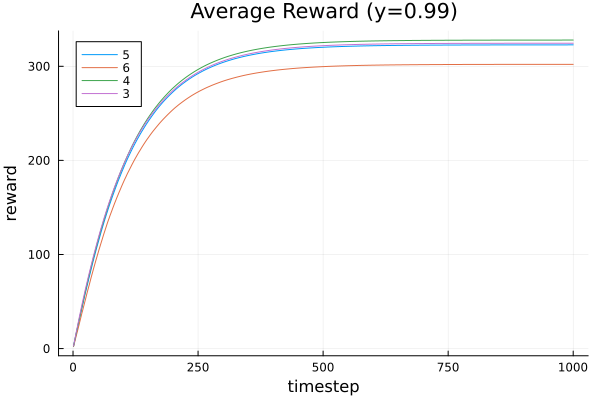

In [57]:
# aibp: active, infinite, best arm, penalty, discount=0.99, max_depth=6
ids_aibp99_6 = ["active_infinite_23417_19486", "active_infinite_23417_20013", "active_infinite_23417_201218", "active_infinite_23417_202250", "active_infinite_23417_203535", "active_infinite_23417_204533", "active_infinite_23417_205541", "active_infinite_23417_210320", "active_infinite_23417_211111", "active_infinite_23417_21195", "active_infinite_23417_212839", "active_infinite_23417_213818", "active_infinite_23417_214829", "active_infinite_23417_215853", "active_infinite_23417_220817", "active_infinite_23417_222118", "active_infinite_23417_223252", "active_infinite_23417_22416", "active_infinite_23417_224849", "active_infinite_23417_22570"]

# aibp: active, infinite, best arm, penalty, discount=0.99, max_depth=4
ids_aibp99_4 = ["active_infinite_23417_161057", "active_infinite_23417_162218", "active_infinite_23417_16299", "active_infinite_23417_16363", "active_infinite_23417_164458", "active_infinite_23417_174416", "active_infinite_23417_175038", "active_infinite_23417_175656", "active_infinite_23417_180234", "active_infinite_23417_180947", "active_infinite_23417_182737", "active_infinite_23417_183431", "active_infinite_23417_184427", "active_infinite_23417_185146", "active_infinite_23417_185918", "active_infinite_23417_191020", "active_infinite_23417_19224", "active_infinite_23417_192817", "active_infinite_23417_193458", "active_infinite_23417_194158"]

# aibp: active, infinite, best arm, penalty, discount=0.99, max_depth=3
ids_aibp99_3 = ["active_infinite_23418_112656", "active_infinite_23418_113346", "active_infinite_23418_113828", "active_infinite_23418_114425", "active_infinite_23418_115119", "active_infinite_23418_115852", "active_infinite_23418_120557", "active_infinite_23418_121833", "active_infinite_23418_12258", "active_infinite_23418_123127", "active_infinite_23418_123717", "active_infinite_23418_124212", "active_infinite_23418_124810", "active_infinite_23418_125415", "active_infinite_23418_130024", "active_infinite_23418_130750", "active_infinite_23418_131310", "active_infinite_23418_131851", "active_infinite_23418_132452", "active_infinite_23418_133114"]

s_aibp99_6, t_aibp99_6, a_aibp99_6, r_aibp99_6 = Import.import_IDs(ids_aibp99_6, runs, directory="..")
s_aibp99_4, t_aibp99_4, a_aibp99_4, r_aibp99_4 = Import.import_IDs(ids_aibp99_4, runs, directory="..")
s_aibp99_3, t_aibp99_3, a_aibp99_3, r_aibp99_3 = Import.import_IDs(ids_aibp99_3, runs, directory="..")

labels = ["5" "6" "4" "3"]
r = [r_aibp, r_aibp99_6, r_aibp99_4, r_aibp99_3]

Figs.plot_cumulative_avg_r_multiple_experiments(r, 0.99, labels, "Average Reward (y=0.99)")

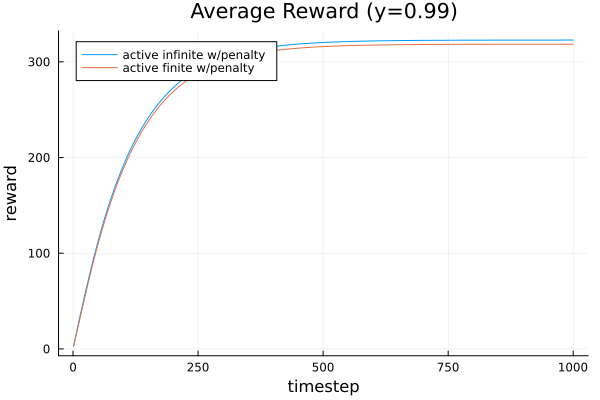

In [58]:
r = [r_aibp, r_afbp, r_pibp, r_aibp99, r_pibp99, r_aibpl99, r_pibpl99, r_n50p, r_rap]
labels = [aibp afbp pibp aibp99 pibp99 aibpl99 pibpl99 n50p rap]

r = [r_aibp, r_afbp]

Figs.plot_cumulative_avg_r_multiple_experiments(r, 0.99, labels, "Average Reward (y=0.99)")

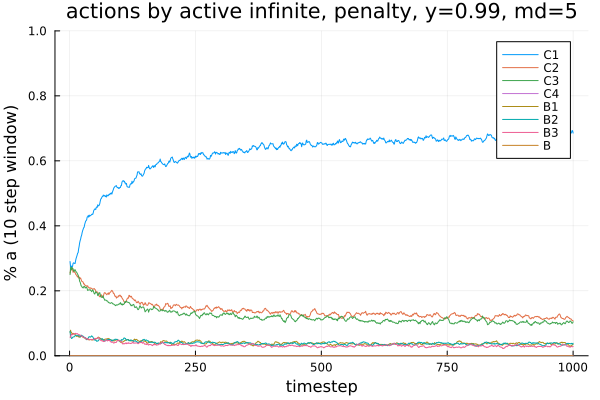

In [46]:
alg = aibp99
act = a_aibp99
Figs.plot_proportion_actions_all(act, actions, window, "actions by "*alg)

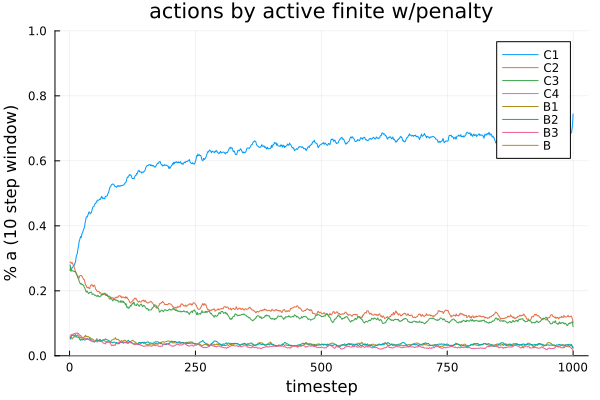

In [45]:
alg = afbp
act = a_afbp
Figs.plot_proportion_actions_all(act, actions, window, "actions by "*alg)

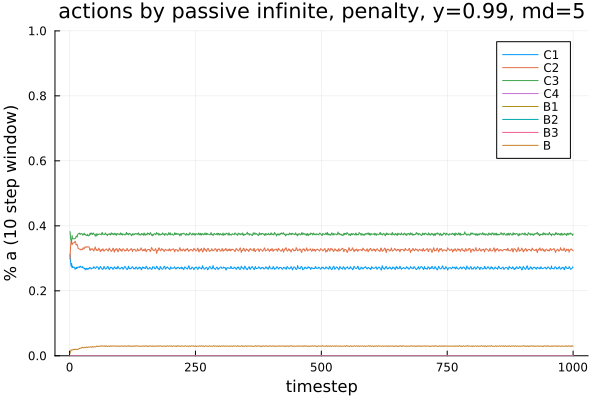

In [34]:
alg = pibp99
act = a_pibp99
Figs.plot_proportion_actions_all(act, actions, window, "actions by "*alg)

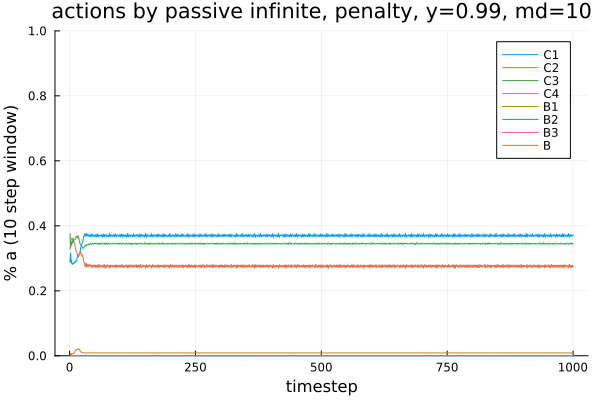

In [35]:
alg = pibpl99
act = a_pibpl99
Figs.plot_proportion_actions_all(act, actions, window, "actions by "*alg)

In [36]:
function plot_actions_in_list_rolling_multiple_experiments(a, a_list::Array{String}, window::Int, labels, title::String)
    exps = length(a)
    runs = minimum([length(x) for x in a])
    time = minimum([length(x[1]) for x in a])
    @assert time/window >= 2
    
    a_prop = Array{Vector{Float64}}(undef, exps)
    for exp in 1:exps
        a_prop[exp] = get_proportion_actions_in_list_rolling(a[exp], window, a_list, runs, time)
    end
        
    plot(collect(1:time), a_prop,
        ylims = (0,1.),
        xlabel = "timestep",
        ylabel = "avg percent of actions",
        labels = labels,
        title = title*string(a_list))
end

function get_proportion_actions_in_list_rolling(a, window::Int, a_list::Array{String}, runs, time)
    @assert time/window >= 2
    
    valid_a = [[arm in a_list for arm in a[i]] for i in 1:runs]
    avg_valid_a = [mean([x[i] for x in valid_a]) for i in 1:time]
    println([x[100] for x in valid_a])
    println(avg_valid_a[100])
    avg_moving_window_percent_valid = [i < window ? mean(avg_valid_a[begin:i]) : mean(avg_valid_a[i-window+1:i]) for i in 1:length(avg_valid_a)]

    return avg_moving_window_percent_valid
end

get_proportion_actions_in_list_rolling (generic function with 1 method)

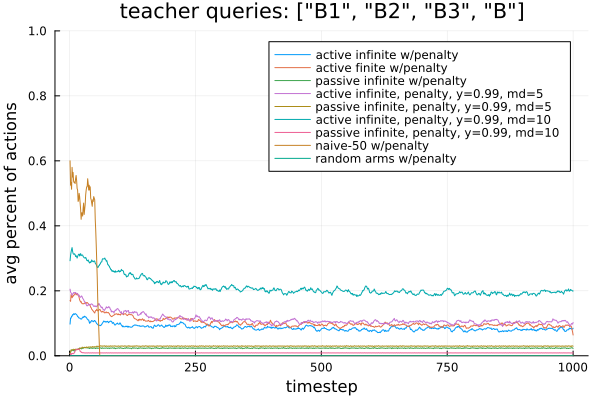

In [50]:
a = [a_aibp, a_afbp, a_pibp, a_aibp99, a_pibp99, a_aibpl99, a_pibpl99, a_n50p, a_rap]
labels = [aibp afbp pibp aibp99 pibp99 aibpl99 pibpl99 n50p rap]
Figs.plot_actions_in_list_rolling_multiple_experiments(a, ["B1", "B2", "B3", "B"], window, labels, "teacher queries: ")


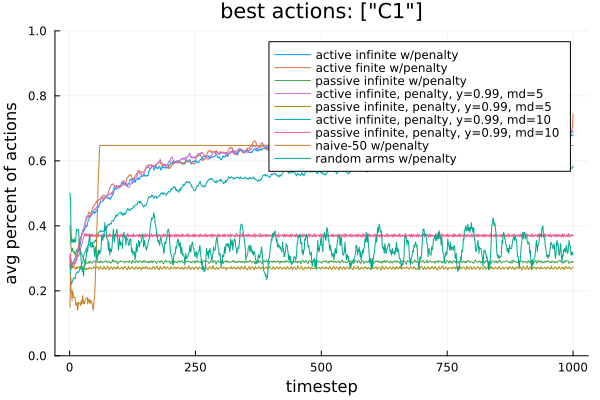

In [49]:
a = [a_aibp, a_afbp, a_pibp, a_aibp99, a_pibp99, a_aibpl99, a_pibpl99, a_n50p, a_rap]
labels = [aibp afbp pibp aibp99 pibp99 aibpl99 pibpl99 n50p rap]
Figs.plot_actions_in_list_rolling_multiple_experiments(a, ["C1"], window, labels, "best actions: ")

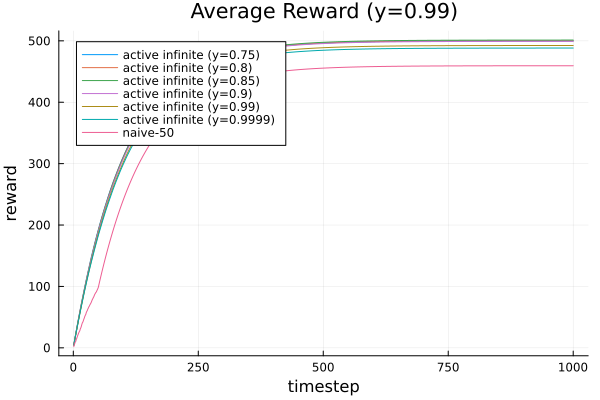

In [12]:
r = [r_aic75, r_aic8, r_aic85, r_aic, r_aic99, r_aic9999, r_n50]
labels = [aic*" (y=0.75)" aic*" (y=0.8)" aic*" (y=0.85)" aic*" (y=0.9)" aic*" (y=0.99)" aic*" (y=0.9999)" n50]
Figs.plot_cumulative_avg_r_multiple_experiments(r, 0.99, labels, "Average Reward (y=0.99)")

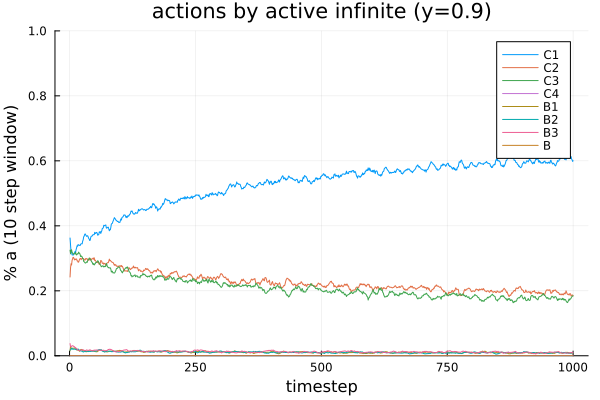

In [13]:
alg = aic*" (y=0.9)"
act = a_aic
Figs.plot_proportion_actions_all(act, actions, window, "actions by "*alg)

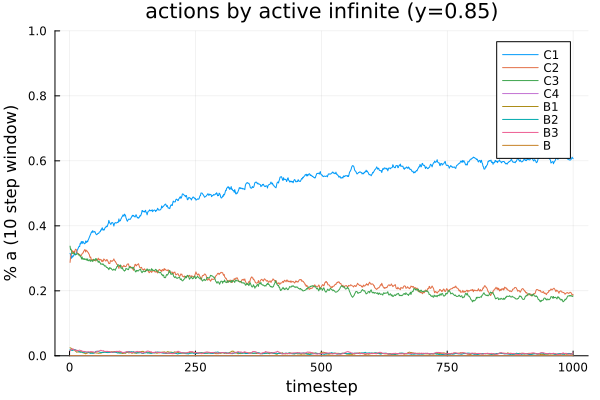

In [14]:
alg = aic*" (y=0.85)"
act = a_aic85
Figs.plot_proportion_actions_all(act, actions, window, "actions by "*alg)

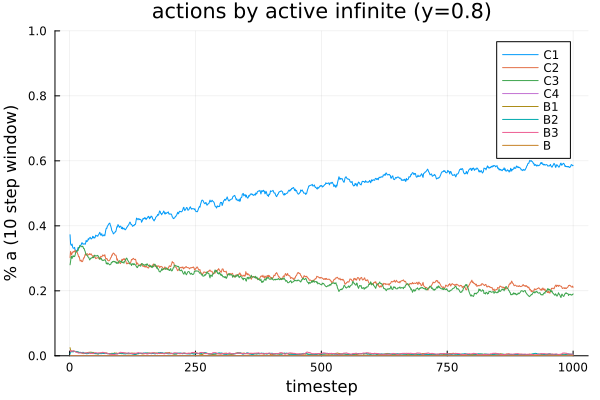

In [15]:
alg = aic*" (y=0.8)"
act = a_aic8
Figs.plot_proportion_actions_all(act, actions, window, "actions by "*alg)

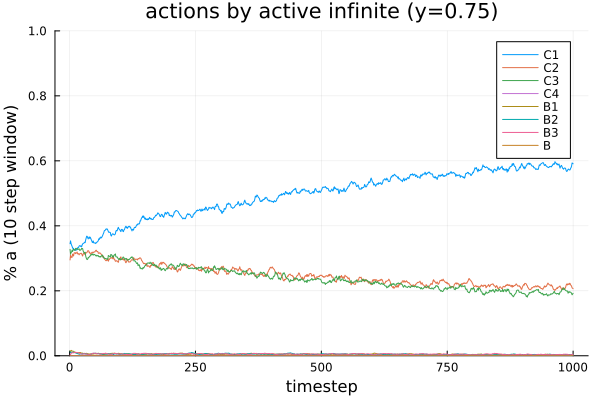

In [16]:
alg = aic*" (y=0.75)"
act = a_aic75
Figs.plot_proportion_actions_all(act, actions, window, "actions by "*alg)

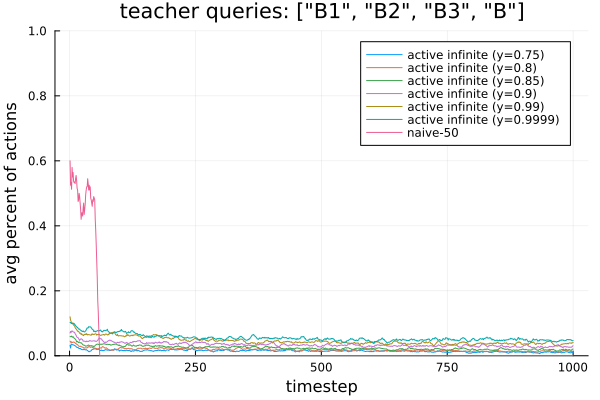

In [17]:
a = [a_aic75, a_aic8, a_aic85, a_aic, a_aic99, a_aic9999, a_n50]
labels = [aic*" (y=0.75)" aic*" (y=0.8)" aic*" (y=0.85)" aic*" (y=0.9)" aic*" (y=0.99)" aic*" (y=0.9999)" n50]
Figs.plot_actions_in_list_rolling_multiple_experiments(a, ["B1", "B2", "B3", "B"], window, labels, "teacher queries: ")

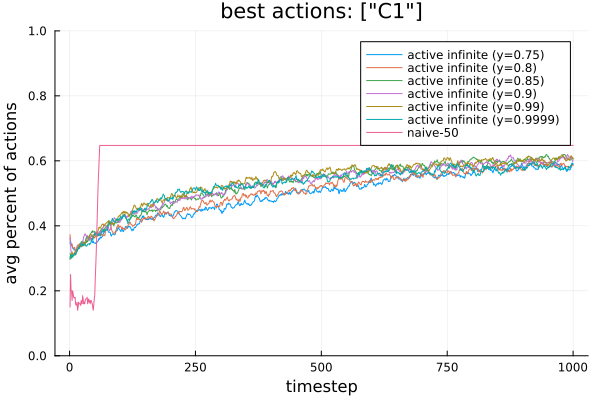

In [18]:
a = [a_aic75, a_aic8, a_aic85, a_aic, a_aic99, a_aic9999, a_n50]
labels = [aic*" (y=0.75)" aic*" (y=0.8)" aic*" (y=0.85)" aic*" (y=0.9)" aic*" (y=0.99)" aic*" (y=0.9999)" n50]
Figs.plot_actions_in_list_rolling_multiple_experiments(a, ["C1"], window, labels, "best actions: ")

In [19]:
function mode(cdf::Vector{Float64})
    # Initialize an empty Vector{Float} to store the marginal probabilities
    marginal_prob = Vector{Float64}(undef, length(cdf))
    # Set the first element of the marginal probability vector to the first element of the cdf
    marginal_prob[1] = cdf[1]
    # Loop through each element in the cdf starting from the second element
    for i in 2:length(cdf)
        # Calculate the difference between the current element and the previous element in the cdf
        diff_cdf = cdf[i] - cdf[i-1]
        # Set the current element of the marginal probability vector to diff_cdf
        marginal_prob[i] = diff_cdf
    end
    # Return the marginal probability vector
    return argmax(marginal_prob)
end

a = [.10, .13, .13, .16]
calc_marginal_prob(a)

LoadError: UndefVarError: calc_marginal_prob not defined